In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from math import floor, ceil
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

# Introduction

The idea behind principal component analysis (PCA) is simple: We have a compression problem and we wish to minimize losses. Let $\mathbb{R}^n$ be the true feature space and $\mathbb{R}^p$, $p<n$, the code space. Let $\pi:\mathbb{R}^n\to\mathbb{R}^p$ and $r:\mathbb{R}^p\to \mathbb{R}^n$. The reconstruction map which maps a feature, $x\in\mathbb R^n$, to its lossy counterpart in the true feature space is simply given by $(r\circ \pi)(x)$. Suppose all these maps are linear:
$$
r(c) = D c
$$

with $D$, a linear operator that may be called a decoder of the code $c\in\mathbb R^p$. The first step is to determine the optimal code, $c_*$. The natural error metric is 

$$
\|x-r(c)\|_{2}
$$

with associated surrogate loss function

$$
L = \|x-r(c)\|_{2}^2.
$$

Then 

$$
\begin{aligned}
 c_*&=\text{argmin}_c\|x-r(c)\|_2^2 \\
 &= \text{argmin}_c \underbrace{(x-Dc)^T(x-Dc)}_{\pi_c(x)}\\
 &=D^Tx
\end{aligned}
$$

Thus, as one might have expected, $\pi:x\mapsto D^T x$ is the optimal encoder. It is rather tedious to determine the optimal decoder, $D$. It turns out to be a matrix of eigenvectors of $XX^T$ of highest eigenvalue where $X$ may be interpreted as the data at hand- $X\in \mathbb{R}^n\otimes\mathbb{R}^m$ such that $X|_{\mathbb R^n}=x$ is a feature vector. These are the principal components. Interpreted statistically, 

$$
PCA:Data \mapsto \{d_i\}_{i\leq p}\in\mathbb{R}^p
$$

where $\{d_i\}_{i\leq p}$ is an orthonormal basis for the data that capture the directions of maximal correlation in the data. Thus PCA is equivalent to the diagonalization of the correlation matrix of the data or, more directly, the SVD of the data. If $D$ is a matrix of principal components, $w_i$, then the code is simply the inner product 

$$
D^Tx_i = \langle x_i, d_i\rangle=c_i\in \mathbb R^p
$$

# Implementation

It is straightforward to implement a PCA algorithm based on the eigendecomposition of a correlation matrix:

In [4]:
def PCA(data, p):
    # Assuming standardized data
    corr = np.dot(data, data.T)
    u, v = np.linalg.eig(corr)
    idx = u.argsort()[::-1]   
    v = v[:,idx]
    return v[:,0:int(p)]

Let's create a simple 2d random data set and observe that the PCA algorithm pick out the direction of maximal variance:

(array([  7.,  21.,  65., 138., 214., 235., 178., 101.,  29.,  12.]),
 array([-1.23312446, -0.99742079, -0.76171713, -0.52601347, -0.29030981,
        -0.05460614,  0.18109752,  0.41680118,  0.65250485,  0.88820851,
         1.12391217]),
 <a list of 10 Patch objects>)

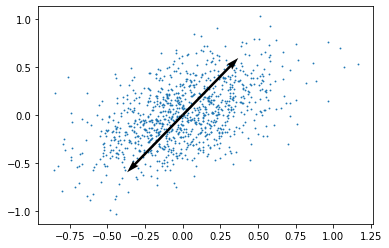

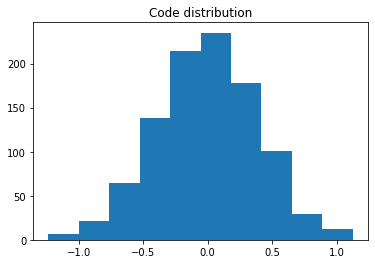

In [5]:
x = np.random.multivariate_normal(np.array([0,0]), np.array([[1,1/2],[1/2,1]])/10, 1000).T
y = PCA(x, 1)
plt.figure()
plt.scatter(x=x[0], y=x[1], s=.7)
plt.quiver( 5*y[0], 5*y[1], scale=21)
plt.quiver( -5*y[0], -5*y[1], scale=21)
plt.figure()
plt.title("Code distribution")
plt.hist(np.dot(y.T, x)[0, :])

# Neural PCA

Notice that $c_i=\langle x_i, d_i\rangle$ can be realized with a single linear neuron. Let $w_i:=d_i$ since the principal component will now be interpreted as a weight vector. Suppose we're wanting to compress our data to the real line. Then
$$
y =  \sum_i w_i x_i
$$

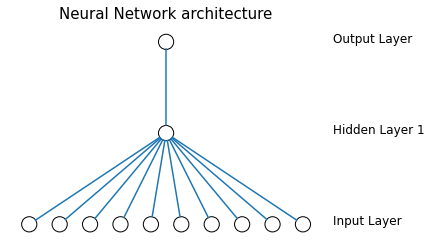

In [7]:
from drawNN import *
network = DrawNN( [10,1,1] )
network.draw()

Where, in the diagram, the hidden layer consists of a single neuron with activation $\phi(x)=x$. In general then, one can construct weight matrix $W_{ij} = w_i^{(j)}$. This is simply our decoder matrix from before: It is a matrix with each column a principal vector. For a reduction to a set of three principal components, one would need the following architecture,

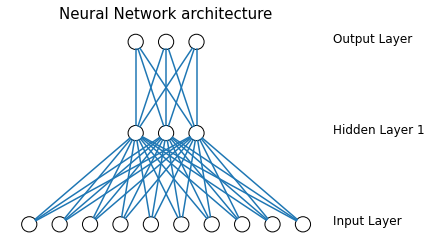

In [8]:
from drawNN import *
network = DrawNN( [10,3,3] )
network.draw()

with output given by $\vec y = W^T \vec x$ (as we derived initially). Now, one has to ask, how come the output is a set of principal components? Alternatively, does the trained NN guarantee that $W$ will be optimized in such a way that it ends up being the optimal encoder of information. 

To this end, consider the Hebbian learning (at rate $\eta$) rule
$$
\Delta w_t := w_{t+1}-w_t = \eta \underbrace{(w^T x_t)}_{y_t} x^T_t
$$
which states that a change in neuronal weight is proportional to *correlation* between $x$ and $y=w^T x$. Then, the expected learning rate change is given by 

$$
\begin{aligned}
\mathbb{E} [\Delta w] &= \eta \mathbb E[w^T x_t x_t^T] \\
                      &= \eta \mathbb{E}[x x^T]\mathbb E [w]\text{  assuming uncorrelated x and w}
\end{aligned}
$$

$\mathbb{E}[x x^T]$ is of course the correlation matrix. As $t\to \infty$, $\mathbb E[\delta w]\to 0$. The properties of correlation matrix imply that $w\to 0$ as $t\to\infty$. However, it turns out that $w=0$ is an unstable fixed point. Thus, as $t\to \infty$, $w$ actually blows up. Algorithmically this is a huge problem. Theoretically it actually gives us all we need. 

First recognize that  $\mathbb{E}[x x^T]\mathbb E [w]$ is obtained by attmepting to minimize $-\mathbb{E}[w^T]\mathbb{E}[x x^T]\mathbb E [w]$ in weight space. However, 
the Hessian is, on average,

$$
-\mathbb{E}[\text{Hess}(\mathbb{E}[w^T]\mathbb{E}[x x^T]\mathbb E [w])]=-\mathbb{E}[x x^T]<0.
$$

This is the origin of the instability. But, the direction along which $w$ is going to blow up, on average, is going to be the eigenvector of this Hessian corresponding to the largest eigenvalue. Therefore, if we can stabilize this algorithm, $y=w^Tx$ will compute a principal component. Fortunately, there are many ways to stabilize this algorithm without changing the preceding reasoning (we still have a net that computes the eigenvectors of a correlation matrix). For instance,

$$
\Delta w_t = \eta y_t x^T_t-\eta y^2_tw_t\text{  [Oja's rule]}
$$

## 2D Gaussian revisited

Let's go back to the bivariate Gaussian and reduce it to a single variable Gaussian using a neural network.

(array([ 18.,  43., 129., 200., 277., 189.,  98.,  29.,  13.,   4.]),
 array([-0.7201264 , -0.55375874, -0.38739112, -0.22102347, -0.05465584,
         0.1117118 ,  0.27807945,  0.44444707,  0.6108147 ,  0.77718234,
         0.94355   ], dtype=float32),
 <a list of 10 Patch objects>)

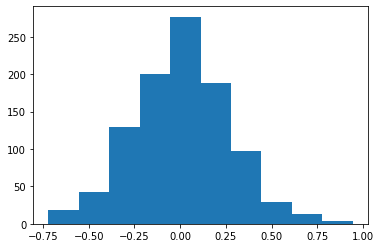

In [44]:
x = np.random.multivariate_normal(np.array([0,0]), np.array([[1,1/2],[1/2,1]])/10, 1000)
model=tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,)),
    tf.keras.layers.Dense(1, activation='linear')])
model.compile(tf.optimizers.RMSprop(0.001), loss='mse')
y = model.predict(x)
plt.hist(y)